In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import re

# Initialize Spark session
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("Book Impact Prediction") \
    .getOrCreate()

# Load the dataset
file_path = './books_task.csv'  
df = spark.read.csv(file_path, header=True, inferSchema=True, 
                    ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True,
                    multiLine=True, quote='"', escape='"')


In [84]:
# Initial EDA
df.show(5)
df.printSchema()
df.describe().show()
print("Total number of rows in the dataset:", df.count())


23/12/31 16:24:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv
23/12/31 16:24:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+
|_c0|               Title|         description|             authors|           publisher|publishedDate|          categories|           Impact|
+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+
|  0|Its Only Art If I...|                NULL|    ['Julie Strain']|Smithsonian Insti...|         1996|['Comics & Graphi...|784.3039243054303|
|  1|Dr. Seuss: Americ...|Philip Nel takes ...|      ['Philip Nel']|           A&C Black|   2005-01-01|['Biography & Aut...|825.4655354138016|
|  2|Wonderful Worship...|This resource inc...|    ['David R. Ray']|             OUP USA|         2000|        ['Religion']|841.7053210126119|
|  3|Whispers of the W...|Julia Thomas find...| ['Veronica Haddon']|           iUniverse|      2005-02|         ['Fiction']|666.4265418233589|

+-------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-----------------+
|summary|               _c0|               Title|         description|            authors|           publisher|     publishedDate|          categories|           Impact|
+-------+------------------+--------------------+--------------------+-------------------+--------------------+------------------+--------------------+-----------------+
|  count|            138724|              138724|              125975|             136001|              138724|            138376|              138724|           138724|
|   mean|103639.46568726392|  1247.5555555555557|  1.4285714285714286|               NULL|             51495.0|1993.4554169957207|                NULL| 786.763661968161|
| stddev| 61169.08229994296|   817.2282592873167|  0.9759000729485332|               NULL|                NULL|  20.5807728797189|                NULL

Total number of rows in the dataset: 138724


# Data Preprocessing

In [85]:
# Function to extract publish year
def extract_year(date_str):
    if not date_str:
        return None
    match = re.match(r'^(\d{4})', date_str)
    return int(match.group(1)) if match else None

extract_year_udf = udf(extract_year, IntegerType())
df = df.withColumn("publish_year", extract_year_udf(df["publishedDate"]))



In [86]:
# Processing categories and authors since its a string that contaisn a list so converting it to an array of strings
def process_categories(cat_str):
    if cat_str and re.match(r'^\[.*\]$', cat_str):
        return cat_str.strip("[]").split(", ")
    else:
        return None

process_categories_udf = udf(process_categories, ArrayType(StringType()))
df = df.withColumn("processed_categories", process_categories_udf(df["categories"]))

# Process authors
def process_authors(author_str):
    if author_str and re.match(r"^\[.*\]$", author_str):
        authors = re.findall(r"\"(.*?)\"|\'(.*?)\'", author_str)
        processed_authors = [name for t in authors for name in t if name]
        return processed_authors if processed_authors else None
    else:
        return None

process_authors_udf = udf(process_authors, ArrayType(StringType()))
df = df.withColumn("processed_authors", process_authors_udf(col("authors")))



In [87]:
# Distribution of books by publish_year
df.groupBy("publish_year").count().orderBy("count",ascending=False).show()

+------------+-----+
|publish_year|count|
+------------+-----+
|        2004| 7196|
|        2005| 6978|
|        2003| 6794|
|        2002| 6400|
|        2000| 6084|
|        2001| 5857|
|        1999| 5478|
|        2012| 5075|
|        2013| 4859|
|        1998| 4803|
|        2011| 4467|
|        2006| 4418|
|        2014| 4141|
|        1997| 4050|
|        2009| 3843|
|        2010| 3826|
|        2007| 3264|
|        1996| 3231|
|        2015| 3172|
|        2008| 2848|
+------------+-----+
only showing top 20 rows



In [88]:
# Explode the authors array into individual rows
exploded_df = df.withColumn("individual_author", explode(col("processed_authors")))

# Count the number of unique authors
unique_authors_count = exploded_df.select("individual_author").distinct().count()
print(f"Number of unique authors: {unique_authors_count}")

# Authors distribution
author_distribution = exploded_df.groupBy("individual_author").count().orderBy("count", ascending=False)
print("Top 100 authors by count:")
author_distribution.show(100)



Number of unique authors: 120025
Top 100 authors by count:


+--------------------+-----+
|   individual_author|count|
+--------------------+-----+
|           Rose Arny|  236|
|Library of Congre...|  164|
| William Shakespeare|  126|
|       Louis L'Amour|  110|
|     Agatha Christie|  103|
|             Various|   71|
|       Lonely Planet|   70|
|     Francine Pascal|   68|
|          Mark Twain|   65|
|Erle Stanley Gardner|   64|
|       Ann M. Martin|   62|
|     Rudyard Kipling|   62|
|Edgar Rice Burroughs|   61|
|       Carolyn Keene|   60|
|                  DK|   59|
|        Isaac Asimov|   56|
|        Nora Roberts|   56|
|      John Steinbeck|   55|
|     Charles Dickens|   52|
|        Stephen King|   50|
|         Jane Austen|   49|
|     Georgette Heyer|   48|
|         Henry James|   48|
|National Research...|   47|
|           Zane Grey|   46|
|       Lewis Carroll|   45|
|     Edgar Allan Poe|   45|
|        Andre Norton|   44|
|         C. S. Lewis|   44|
|         Oscar Wilde|   44|
|           Zondervan|   43|
|    Jerry B. 

In [89]:
# Explode the categories array into individual rows
exploded_df = df.withColumn("individual_category", explode(col("processed_categories")))

# Count the number of unique categories
unique_categories_count = exploded_df.select("individual_category").distinct().count()
print(f"Number of unique categories: {unique_categories_count}")

# Categories distribution
category_distribution = exploded_df.groupBy("individual_category").count().orderBy("count", ascending=False)
print("Top 100 categories by count:")
category_distribution.show(50)



Number of unique categories: 105
Top 100 categories by count:


+--------------------+-----+
| individual_category|count|
+--------------------+-----+
|           'Fiction'|23419|
|          'Religion'| 9459|
|           'History'| 9330|
|  'Juvenile Fiction'| 6643|
|'Biography & Auto...| 6324|
|'Business & Econo...| 5625|
|         'Computers'| 4312|
|    'Social Science'| 3834|
|'Juvenile Nonfict...| 3446|
|           'Science'| 2623|
|         'Education'| 2611|
|           'Cooking'| 2445|
|'Sports & Recreat...| 2267|
|'Family & Relatio...| 2178|
|'Literary Criticism'| 2147|
|             'Music'| 2106|
|           'Medical'| 2079|
|               'Art'| 2054|
|      Mind & Spirit'| 2049|
|               'Body| 2049|
|'Language Arts & ...| 2036|
|  'Health & Fitness'| 2030|
| 'Political Science'| 1955|
|        'Psychology'| 1913|
|        'Philosophy'| 1864|
|            'Travel'| 1812|
|'Technology & Eng...| 1662|
|         'Self-Help'| 1519|
|            'Poetry'| 1500|
|'Foreign Language...| 1404|
|  'Crafts & Hobbies'| 1350|
|   'Performin

In [90]:
# Count the number of unique publishers
unique_publishers_count = df.select("publisher").distinct().count()
print(f"Number of unique publishers: {unique_publishers_count}")

# Publisher distribution
publisher_distribution = df.groupBy("publisher").count().orderBy("count", ascending=False)
print("Top 100 publishers by count:")
publisher_distribution.show(100)



Number of unique publishers: 12851
Top 100 publishers by count:


+--------------------+-----+
|           publisher|count|
+--------------------+-----+
|     Tan Books & Pub| 3635|
|  Simon and Schuster| 3600|
|Smithsonian Insti...| 3216|
|             Penguin| 2788|
|Wm. B. Eerdmans P...| 2563|
|           Routledge| 2371|
|   John Wiley & Sons| 1984|
|      Harper Collins| 1959|
|Cambridge Univers...| 1478|
|           A&C Black| 1355|
|           Macmillan| 1215|
|             OUP USA| 1187|
|    Berg Pub Limited| 1169|
| Courier Corporation| 1116|
|           iUniverse| 1057|
|Bloomsbury Publis...| 1031|
|     Open Road Media|  983|
|             Vintage|  976|
|Springer Science ...|  885|
|Houghton Mifflin ...|  878|
|Oxford University...|  759|
|        Random House|  751|
|         Hachette UK|  724|
|Princeton Univers...|  619|
|Oxford University...|  604|
|Cumberland House ...|  590|
|W. W. Norton & Co...|  573|
|Univ of Californi...|  560|
|           Harlequin|  555|
|McGraw Hill Profe...|  548|
|       HarperCollins|  539|
|           CR

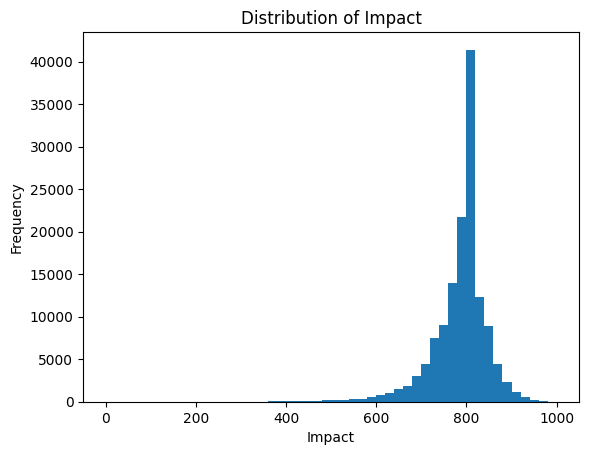

In [91]:
# Convert 'Impact' column to Pandas DataFrame
impact_pd = df.select("Impact").toPandas()

# Plotting the histogram
plt.hist(impact_pd['Impact'], bins=50)
plt.title('Distribution of Impact')
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.show()

In [92]:
percentiles = [i / 10 for i in range(11)]

# Calculate percentiles
impact_percentiles = df.stat.approxQuantile("Impact", percentiles, 0)
percentile_values = {f"{int(p*100)}th percentile": val for p, val in zip(percentiles, impact_percentiles)}

for percentile, value in percentile_values.items():
    print(f"{percentile}: {value}")


0th percentile: 0.0
10th percentile: 718.3813652211307
20th percentile: 755.9182978039748
30th percentile: 776.2309491765689
40th percentile: 784.3039243054303
50th percentile: 805.5685400829483
60th percentile: 805.5685400829483
70th percentile: 812.2857832807687
80th percentile: 823.9607318560921
90th percentile: 845.4664825825195
100th percentile: 1000.0


# Feature Engineering

In [93]:
# Define a function for text preprocessing on an array of strings
def preprocess_text(text_arr):
    if text_arr:
        # Apply preprocessing to each string element in the array
        processed_text_arr = [preprocess_string(text) for text in text_arr]
        return processed_text_arr
    else:
        return None

def preprocess_string(text):
    if text:
        # Convert to lowercase
        text = text.lower()
        # Replace multiple spaces with a single underscore
        text = '_'.join(text.split())
        # Remove special characters (except underscores)
        text = ''.join(e if e.isalnum() or e == '_' else '' for e in text)
        return text
    else:
        return None


# Define a UDF for text preprocessing
preprocess_text_udf = udf(preprocess_text, ArrayType(StringType()))

# Apply text preprocessing to processed_categories and processed_authors
df = df.withColumn("processed_categories", preprocess_text_udf(col("processed_categories")))
df = df.withColumn("processed_authors", preprocess_text_udf(col("processed_authors")))

df = df.withColumn("processed_authors", when(col("processed_authors").isNull(), array(lit("Other"))).otherwise(col("processed_authors")))

In [94]:

# Add columns for counting categories and authors
df = df.withColumn("num_categories", size(col("processed_categories")))
df = df.withColumn("num_authors", size(col("processed_authors")))

# Explode the categories and authors
df_categories = df.withColumn("category", explode(col("processed_categories")))
df_authors = df.withColumn("author", explode(col("processed_authors")))

# Find top 100 categories and authors
top_categories = df_categories.groupBy("category").count().orderBy(col("count").desc()).limit(100).rdd.map(lambda row: row[0]).collect()
top_authors = df_authors.groupBy("author").count().orderBy(col("count").desc()).limit(100).rdd.map(lambda row: row[0]).collect()



def filter_top_entities(arr, top_entities):
    # Check if the array is None
    if arr is None:
        return None  # or return ['Other'] if you prefer to treat None as 'Other'
    else:
        return [x if x in top_entities else 'Other' for x in arr]


filter_udf = udf(filter_top_entities, ArrayType(StringType()))

df = df.withColumn("filtered_categories", filter_udf(col("processed_categories"), array([lit(x) for x in top_categories])))
df = df.withColumn("filtered_authors", filter_udf(col("processed_authors"), array([lit(x) for x in top_authors])))

for category in top_categories:
    df = df.withColumn(f"cat_{category}", array_contains(col("filtered_categories"), category).cast("integer"))

for author in top_authors:
    df = df.withColumn(f"auth_{author}", array_contains(col("filtered_authors"), author).cast("integer"))


# List of one-hot encoded columns for categories
category_columns = [f"cat_{category}" for category in top_categories]

# List of one-hot encoded columns for authors
author_columns = [f"auth_{author}" for author in top_authors]

# Create a VectorAssembler for categories
category_assembler = VectorAssembler(
    inputCols=category_columns,
    outputCol="category_vector",
      handleInvalid="keep"  # or "skip"
)

# Create a VectorAssembler for authors
author_assembler = VectorAssembler(
    inputCols=author_columns,
    outputCol="author_vector",
      handleInvalid="keep"  # or 
)

# Apply the VectorAssembler to your DataFrame
df = category_assembler.transform(df)
df = author_assembler.transform(df)



In [95]:
df.show()

23/12/31 16:25:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+--------------------+--------------------+--------------+-----------+--------------------+--------------------+-----------+------------+-----------+--------------------+----------------------------+-----------------------+-------------+------------------+-----------------------+-----------+-------------+-----------+----------------------+-------------------------+----------------------+---------+-----------+-------+--------+----------------+------------------------------+-------------------+---------------------+--------------+--------------+----------+---------------------------+------------+----------+--------------------------+-------------------+-------------------+-------------+---------------+--------------------------+----------+----------------+------------------+-------+---------+---------------+-----------------------+-----

In [96]:
# String Indexer for publisher
df = df.fillna({'description': '', 'Title': ''})
publisher_indexer = StringIndexer(inputCol="publisher", outputCol="publisherIndex")

# Tokenizer and StopWordsRemover for 'description'
tokenizer_desc = Tokenizer(inputCol="description", outputCol="description_tokens")
remover_desc = StopWordsRemover(inputCol="description_tokens", outputCol="description_filtered")

# Tokenizer and StopWordsRemover for 'title'
tokenizer_title = Tokenizer(inputCol="Title", outputCol="title_tokens")
remover_title = StopWordsRemover(inputCol="title_tokens", outputCol="title_filtered")

# HashingTF and IDF for 'description'
hashingTF_desc = HashingTF(inputCol="description_filtered", outputCol="description_rawFeatures", numFeatures=200)
idf_desc = IDF(inputCol="description_rawFeatures", outputCol="description_features")

# HashingTF and IDF for 'title'
hashingTF_title = HashingTF(inputCol="title_filtered", outputCol="title_rawFeatures", numFeatures=200)
idf_title = IDF(inputCol="title_rawFeatures", outputCol="title_features")


In [97]:
# Pipeline for transformations
pipeline = Pipeline(stages=[publisher_indexer, tokenizer_desc, remover_desc, 
                            tokenizer_title, remover_title, hashingTF_desc, idf_desc, 
                            hashingTF_title, idf_title])

# Fit and transform
model = pipeline.fit(df)
df_transformed = model.transform(df)



In [98]:
df_transformed.show()

23/12/31 16:25:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-----------------+------------+--------------------+--------------------+--------------+-----------+--------------------+--------------------+-----------+------------+-----------+--------------------+----------------------------+-----------------------+-------------+------------------+-----------------------+-----------+-------------+-----------+----------------------+-------------------------+----------------------+---------+-----------+-------+--------+----------------+------------------------------+-------------------+---------------------+--------------+--------------+----------+---------------------------+------------+----------+--------------------------+-------------------+-------------------+-------------+---------------+--------------------------+----------+----------------+------------------+-------+---------+---------------+-----------------------+-----

In [99]:
# Calculate the 1st and 99th percentiles for publish_year
bounds = df_transformed.approxQuantile("publish_year", [0.01, 0.99], 0)
lower_bound, upper_bound = bounds

# Filter out rows where publish_year is outside the 1st and 99th percentiles
df_filtered = df_transformed.filter((col("publish_year") >= lower_bound) & (col("publish_year") <= upper_bound))


In [100]:
selected_features = [
    "publish_year",
    'num_categories',
    'num_authors',
    "description_features",
    "title_features",
    "publisherIndex",
    "author_vector",
    "category_vector"
]

one_hot_columns = [col for col in df.columns if col.startswith("cat_") or col.startswith("auth_")]

selected_features

['publish_year',
 'num_categories',
 'num_authors',
 'description_features',
 'title_features',
 'publisherIndex',
 'author_vector',
 'category_vector']

In [101]:
from pyspark.ml.feature import VectorAssembler

# List of columns to exclude from the features
exclude_columns = ["Impact"]

# Create a Vector Assembler
vector_assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features"  # Output column containing the feature vector
)

# Transform the dataset to create the feature vector
final_df = vector_assembler.transform(df_filtered)

# Show the final DataFrame with features and target (Impact)
final_df.show(truncate=False)


23/12/31 16:26:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv


+---+-------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [102]:
# writing final feaures to parquet file
final_df.select('_c0','Title','features','Impact').write.parquet('book_featured_data.parquet',mode='overwrite')

23/12/31 16:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1453.0 KiB
23/12/31 16:26:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Title, description, authors, publisher, publishedDate, categories, Impact
 Schema: _c0, Title, description, authors, publisher, publishedDate, categories, Impact
Expected: _c0 but found: 
CSV file: file:///Users/apple/Book-Impact/books_task.csv
